# Библиотеки

In [ ]:
!pip install python-graphblas

In [ ]:
import graphblas as gb
from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread
import numpy as np
import pandas as pd
import timeit

# Проверка неориентированности

In [ ]:
# Проверка не неориентированности
def is_symmetric(matrix):
    # Проверяет, является ли матрица симметричной.
    return matrix.isequal(matrix.T)

def is_integer_matrix(matrix):
  #  Проверяет, содержит ли матрица только целочисленные значения
    return matrix.dtype in [dtypes.INT8, dtypes.INT16, dtypes.INT32, dtypes.INT64, dtypes.UINT8, dtypes.UINT16, dtypes.UINT32, dtypes.UINT64]

def test_matrix(matrix):
    # Тест для проверки симметричности и целочисленности матрицы
    if not is_symmetric(matrix):
        raise ValueError("Матрица должна быть симметричной (неориентированной).")

    if not is_integer_matrix(matrix):
        raise ValueError("Матрица должна содержать только целочисленные значения.")

    print("Матрица прошла все проверки.")


# Задание 1-5

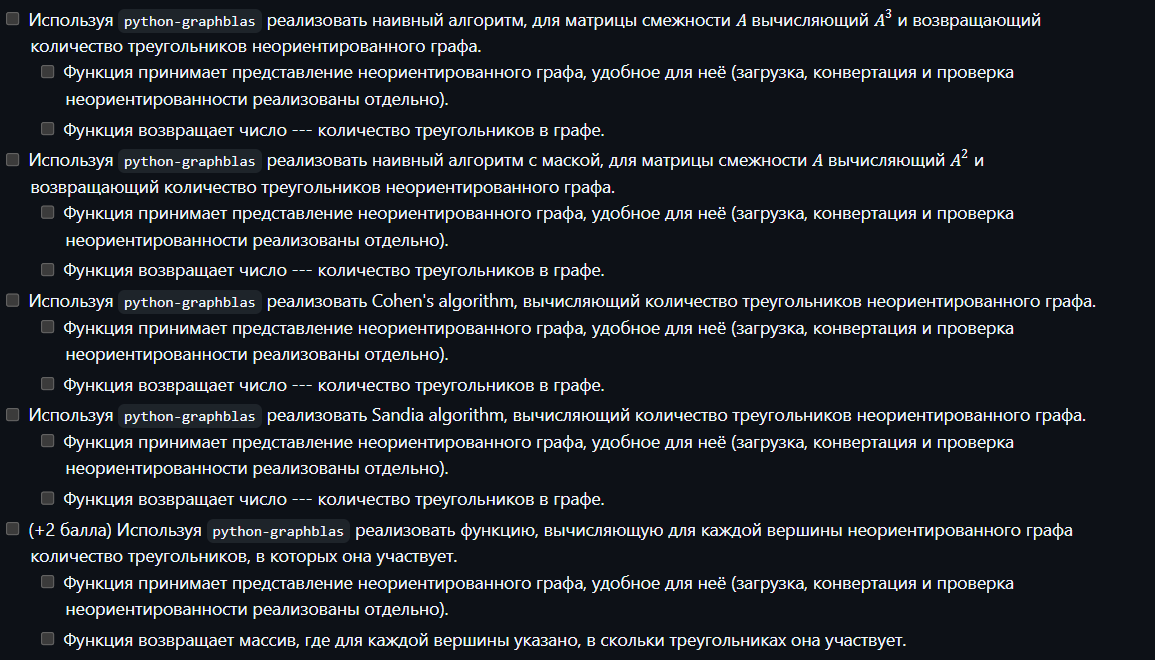

In [ ]:
def naive_A3(A) -> float:
    # Вычисляем A^3
    A3 = A.mxm(A.mxm(A))

    # Выделяем диагональ матрицы, на которой выписаны все пути длины 3
    diag = A3.diag()

    # Находим След и делим на 6 т.к. каждый треугольник был пересчитан 6 раз (по 2м направлениям и 3м вершинам)
    return float(diag.reduce(gb.agg.sum).value or 0) / 6

def naive_mask_A2(A) -> float:
    # Вычисляем A^2:
    A2 = A.mxm(A)

    # Вычисляем маску:
    mask = A.dup(dtype=dtypes.BOOL)

    # Применим маску к матрице A^2:
    masked_A2 = A2.dup(mask=mask)

    # Просуммируем все элементы матрицы, посчитав тем самым количество всех треугольников и также делим на 6
    return float(masked_A2.reduce_scalar(gb.monoid.plus).value or 0) / 6

def cohen(A) -> float:
    # Вычисляем нижнетреугольную матрицу A:
    L = gb.select.tril(A)

    # Вычисляем верхнетреугольную матрицу A:
    U = gb.select.triu(A)

    # Вычисляем маску:
    mask = A.dup(dtype=dtypes.BOOL)

    # Применим маску к произведению L * U
    masked_LU = L.mxm(U).dup(mask=mask)

    # Просуммируем все элементы матрицы, посчитав тем самым количество всех треугольников
    # и также делим на 2, т.к. теперь мы учитываем вершины, но еще не учитываем направление
    return float(masked_LU.reduce_scalar(gb.monoid.plus).value or 0) / 2

def sandia(A) -> float:
    # Вычисляем нижнетреугольную матрицу A:
    L = gb.select.tril(A)

    # Вычисляем маску L:
    mask = L.dup(dtype=dtypes.BOOL)

    # Применяем маску к произведению L * L
    masked_LL = L.mxm(L).dup(mask=mask)

    # Просуммируем все элементы матрицы и получим итоговое число треугольников без повторов
    return float(masked_LL.reduce_scalar(gb.monoid.plus).value or 0)

# Чтобы посчитать количество треугольников, в которых участвует каждая вершина,
# нам необходимо применить наивный алгоритм и поделить для каждой вершины число на 2
def triangles_for_vertices_naive_mask_A2(A) -> np.ndarray:
    # Вычисляем A^2:
    A2 = A.mxm(A)

    # Вычисляем маску:
    mask = A.dup(dtype=dtypes.BOOL)

    # Применим маску к матрице A^2:
    masked_A2 = A2.dup(mask=mask)

    # Вычисляем сумму в каждой строке и делим на 2
    res = masked_A2.reduce_columnwise(monoid.plus) / 2
    return res.to_dense(fill_value=0)

# Тесты для заданий с 1 по 5

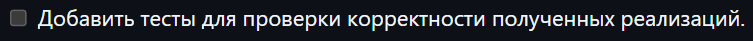

In [ ]:
def test(A):
    result = [naive_A3(A), naive_mask_A2(A), cohen(A), sandia(A)]

    time_naive_A3 = timeit.timeit(lambda: naive_A3(A), number=10)
    time_naive_mask_A2 = timeit.timeit(lambda: naive_mask_A2(A), number=10)
    time_cohen = timeit.timeit(lambda: cohen(A), number=10)
    time_sandia = timeit.timeit(lambda: sandia(A), number=10)

    test_df = pd.DataFrame({
        'Алгоритм': ['naive_A3', 'naive_mask_A2', 'cohen', 'sandia'],
        'Результат': result,
        'Время выполнения (с)': [time_naive_A3, time_naive_mask_A2, time_cohen, time_sandia]
    })

    return test_df

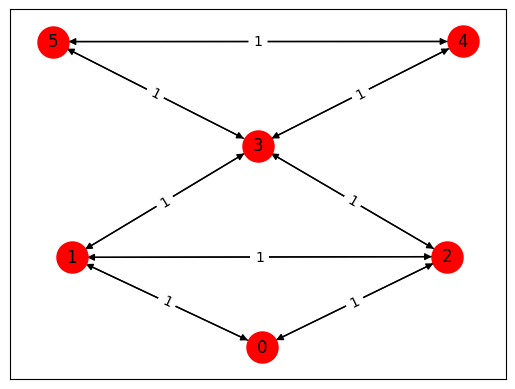

Матрица прошла все проверки.


,Алгоритм,Результат,Время выполнения (с)
0,naive_A3,3.0,0.004007
1,naive_mask_A2,3.0,0.003009
2,cohen,3.0,0.005936
3,sandia,3.0,0.003836


In [ ]:
L = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 1, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0]
])

M = Matrix.from_dense(L, dtype=dtypes.INT64)

# Визуализируем граф
gb.viz.draw(M.dup(mask=M.dup(dtype=dtypes.BOOL)))

# Запускаем тест
test_matrix(M)

test_df = test(M)
test_df

Граф A:
Матрица прошла все проверки.


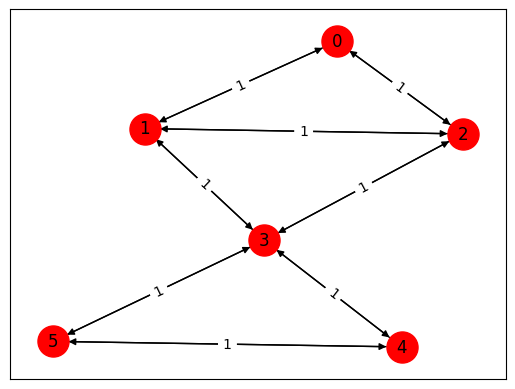

Количество треугольников для каждой вершины в графе A: [1. 2. 2. 2. 1. 1.]
Граф B:
Матрица прошла все проверки.


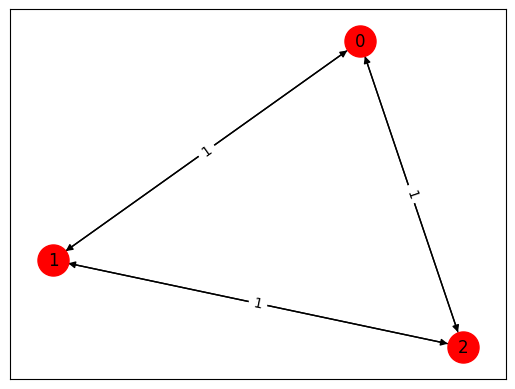

Количество треугольников для каждой вершины в графе B: [1. 1. 1.]

Граф C:
Матрица прошла все проверки.


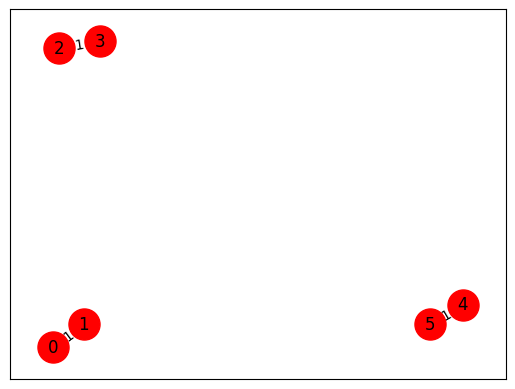

Количество треугольников для каждой вершины в графе С: [0. 0. 0. 0. 0. 0.]


In [ ]:
def test_graphs_triangles_for_vertices_naive_mask_A2():
    L = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 1, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0]
])

    A = Matrix.from_dense(L, dtype=dtypes.INT64)

    print("Граф A:")
    test_matrix(A)
    gb.viz.draw(A.dup(mask=A.dup(dtype=dtypes.BOOL)))
    triangles_A = triangles_for_vertices_naive_mask_A2(M)
    print("Количество треугольников для каждой вершины в графе A:", triangles_A)


    # Пример 2: Граф с треугольниками
    B = np.array([[0, 1, 1],
                  [1, 0, 1],
                  [1, 1, 0]], dtype=int)
    B = Matrix.from_dense(B, dtype=dtypes.INT64)

    print("Граф B:")
    test_matrix(B)
    gb.viz.draw(B.dup(mask=B.dup(dtype=dtypes.BOOL)))
    triangles_B = triangles_for_vertices_naive_mask_A2(B)
    print("Количество треугольников для каждой вершины в графе B:", triangles_B)

    # Пример 3: Граф без треугольников
    С = np.array([
        [0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0]
    ], dtype=int)
    С = Matrix.from_dense(С, dtype=dtypes.INT64)

    print("\nГраф C:")
    test_matrix(С)
    gb.viz.draw(С.dup(mask=С.dup(dtype=dtypes.BOOL)))
    triangles_С = triangles_for_vertices_naive_mask_A2(С)
    print("Количество треугольников для каждой вершины в графе С:", triangles_С)

# Запускаем тест
test_graphs_triangles_for_vertices_naive_mask_A2()

# Задание 6

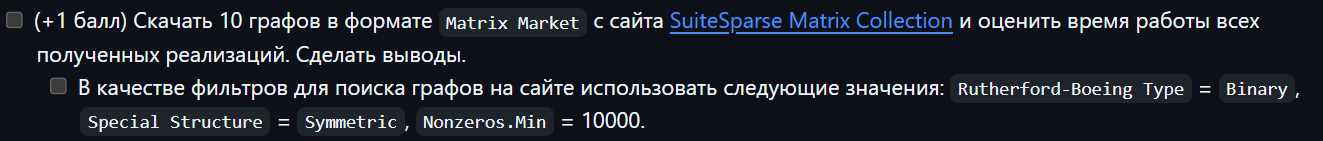

In [ ]:
files = [f"delaunay_n{i:02d}.mtx" for i in range(9, 19)]

for file in files:
    file_path = f"/content/{file}"
    matrix = mmread(file_path)
    print(f"Файл {file} прочитан успешно.")
    print(f'name: {file}; nvals: {matrix.nvals}, nrows: {matrix.nrows}, ncols: {matrix.ncols}')
    test_df = test(matrix)
    print(test_df)

Файл delaunay_n09.mtx прочитан успешно.
name: delaunay_n09.mtx; nvals: 44392, nrows: 767, ncols: 767
        Алгоритм  Результат  Время выполнения (с)
0       naive_A3        0.0              3.711103
1  naive_mask_A2        0.0              0.050719
2          cohen        0.0              0.032137
3         sandia        0.0              0.011959
Файл delaunay_n10.mtx прочитан успешно.
name: delaunay_n10.mtx; nvals: 14542, nrows: 383, ncols: 383
        Алгоритм  Результат  Время выполнения (с)
0       naive_A3        0.0              0.296562
1  naive_mask_A2        0.0              0.012049
2          cohen        0.0              0.009156
3         sandia        0.0              0.005363
Файл delaunay_n11.mtx прочитан успешно.
name: delaunay_n11.mtx; nvals: 12254, nrows: 2048, ncols: 2048
        Алгоритм  Результат  Время выполнения (с)
0       naive_A3     4104.0              0.075176
1  naive_mask_A2     4104.0              0.016581
2          cohen     4104.0              0.01



Выводы:

Наивные алгоритмы — самые медленные из-за отсутствия оптимизаций.

Алгоритм с маской — значительно ускоряет простой наивный алгоритм, но уступает Cohen и Sandia.

Алгоритм Cohen — второй по скорости, но уступает лидеру.

Алгоритм Sandia — самый быстрый на больших данных.

# Задание 7

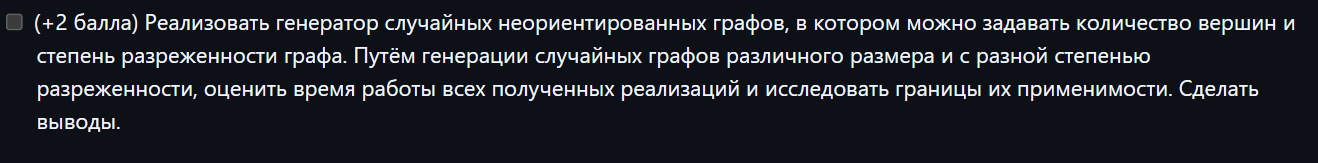

In [ ]:
def generate_random_graph(n, density):
    A = np.random.rand(n, n) < density
    A = np.triu(A, 1)
    A = A + A.T
    A = A.astype(int)
    return Matrix.from_dense(A, dtype=dtypes.INT64)

def generate_random_graph_result():

    ns = [100, 500, 1000]  # Количество вершин
    densities = [0.1, 0.5, 0.9]  # Плотности графов
    data = []

    for n in ns:
        for density in densities:
            print(f"Количество вершин = {n}, Плотности ={density}")
            G = generate_random_graph(n, density)
            results = test(G)
            print(results)

In [ ]:
generate_random_graph_result()

Количество вершин = 100, Плотности =0.1
        Алгоритм  Результат  Время выполнения (с)
0       naive_A3      109.0              0.033638
1  naive_mask_A2      109.0              0.010992
2          cohen      109.0              0.015810
3         sandia      109.0              0.008590
Количество вершин = 100, Плотности =0.5
        Алгоритм  Результат  Время выполнения (с)
0       naive_A3    20474.0              0.032761
1  naive_mask_A2    20474.0              0.019831
2          cohen    20474.0              0.016248
3         sandia    20474.0              0.011930
Количество вершин = 100, Плотности =0.9
        Алгоритм  Результат  Время выполнения (с)
0       naive_A3   118099.0              0.034611
1  naive_mask_A2   118099.0              0.022330
2          cohen   118099.0              0.017195
3         sandia   118099.0              0.011993
Количество вершин = 500, Плотности =0.1
        Алгоритм  Результат  Время выполнения (с)
0       naive_A3    20349.0             

**Выводы из сравнения алгоритмов**

1. **Влияние количества вершин и плотности на время выполнения**:
   - По мере увеличения количества вершин время выполнения всех алгоритмов растет. Это ожидаемо, поскольку объем данных увеличивается.
   - При фиксированном количестве вершин увеличение плотности также приводит к росту времени выполнения, особенно для наивных алгоритмов. Это связано с тем, что более плотные графы содержат больше ребер, что усложняет вычисления.

2. **Сравнение алгоритмов**:
   - **Наивные алгоритмы (naive_A3 и naive_mask_A2)**: Они показывают худшие результаты по времени выполнения, особенно при большом количестве вершин. Использование маски (naive_mask_A2) несколько улучшает ситуацию, но все равно остается медленнее других алгоритмов.
   - **Алгоритм Cohen**: Он демонстрирует более стабильные результаты, чем наивные алгоритмы, но иногда может быть медленнее алгоритма Sandia, особенно на больших данных.
   - **Алгоритм Sandia**: Это самый быстрый алгоритм во всех случаях, особенно заметно на больших объемах данных и при высокой плотности. Он показывает наилучшую производительность и масштабируемость.
